# PyTorch & Matplotlib (& Research) 

This is a ~50 minute crash course. This notebook shows basic pytorch functionality, as well as some plotting good practices, with a touch of research protips. For more in-depth material check out https://github.com/mila-udem/welcome_tutorials/.

This tutorial assumes that you are somewhat familiar with numpy. Ask questions if you are not! :)

Installing stuff:
- Preferably Python3.6+, because we're not Google,
- `pip install numpy scipy matplotlib`,
- `pip install torch torchvision` (see https://pytorch.org/ for more options).


In [1]:
# The base imports. We'll import more later.
import torch
import numpy as np
import matplotlib.pyplot as pp

# An alternative import schema if you are running code on a server:
#   import matplotlib
#   matplotlib.use('agg')
#   import matplotlib.pyplot as pp
# The Agg doesn't require a graphical server (X11) to be running.

The most basic usage of PyTorch you can do is simply to use it as a numpy-on-gpu.

In [2]:
a = torch.arange(6)
B = torch.ones((6, 3))
# a.unsqueeze(i) 'broadcasts' the ith dimension of `a`,
# and is equivalent to a[:, None], a.reshape((10, 1)) or a.reshape((-1, 1)).
C = a.unsqueeze(1) * B
print(C)
print(C.shape)
C = C.transpose(0, 1)
print(C.shape)

# Matrix multiply ("dot")
print(torch.mm(C, B))
# Python3.5+ lets you write this even better:
print(C @ B)

# `tensor` can wrap any numerical numpy array
D = torch.tensor(np.array([[1,2,3]]))
print(D)

tensor([[ 0.,  0.,  0.],
        [ 1.,  1.,  1.],
        [ 2.,  2.,  2.],
        [ 3.,  3.,  3.],
        [ 4.,  4.,  4.],
        [ 5.,  5.,  5.]])
torch.Size([6, 3])
torch.Size([3, 6])
tensor([[ 15.,  15.,  15.],
        [ 15.,  15.,  15.],
        [ 15.,  15.,  15.]])
tensor([[ 15.,  15.,  15.],
        [ 15.,  15.,  15.],
        [ 15.,  15.,  15.]])
tensor([[ 1,  2,  3]])


In [3]:
print(C.sum(), C.sum(0), C.mean(), C.std())

tensor(45.) tensor([  0.,   3.,   6.,   9.,  12.,  15.]) tensor(2.5000) tensor(1.7573)


Notice how all these arrays are wrapped in `tensor`s. This is so that they are interchangeably usable when on a gpu. Fortunately we can retrieve the numpy array with `tensor.numpy()`, or `tensor.item()` if the tensor is a single scalar.

In [4]:
print(C.sum().item(), C.sum(1).numpy())

45.0 [ 15.  15.  15.]


 

### Using the gpu

In [5]:
# We can check if the GPU is available using:
print(torch.cuda.is_available())
# Or use some f-string magic (Python3.6+):
print(f"My gpu {['isnt', 'is'][torch.cuda.is_available()]} available.")

True
My gpu is available.


In [6]:
# The simplest way to use the GPU:
D = C.cuda()
print(D)
D[0, 0] = 42
print(D[0, 0], C[0, 0])

# Now the data is on the GPU, so to get the numpy array we need 
# to copy it back to cpu first. 
print(D.cpu().numpy())
# `item()` does it for you though
print(D.sum(), D.sum().item())
print(D.device)

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.],
        [ 0.,  1.,  2.,  3.,  4.,  5.],
        [ 0.,  1.,  2.,  3.,  4.,  5.]], device='cuda:0')
tensor(42., device='cuda:0') tensor(0.)
[[ 42.   1.   2.   3.   4.   5.]
 [  0.   1.   2.   3.   4.   5.]
 [  0.   1.   2.   3.   4.   5.]]
tensor(87., device='cuda:0') 87.0
cuda:0


## Gradients
I hear gradients are all the rage these days! PyTorch can compute them for you. Similarly to Theano and Tensorflow, PyTorch keeps a graph of computations (but automatically). Using this graph it can compute gradients using automatic differentiation (vs symbolic differentiation in Theano/TF).

By default though, PyTorch will not build the graph unless you ask it to using the `requires_grad` flag.

In [7]:
x = torch.tensor([1,2,3], requires_grad=True)
y = x**2
z = y.sum()

Now we can "backprop" a scalar loss to the nodes in the graph which have the `requires_grad` flag, and the gradient of the loss wrt these nodes will be stored in `.grad`.

In [8]:
z.backward()
print(x.grad)

tensor([ 2,  4,  6])


It is also possible to accumulate the gradient from several losses by asking PyTorch to retain the computation graph after having called `backward`.

In [9]:
x = torch.tensor([1,2,3], requires_grad=True)
y = x**2
z1 = y.sum()
z2 = x.sum()

# dz1/dx = [2, 4, 6]
z1.backward(retain_graph=True)
print(x.grad)
# dz2/dx = [1, 1, 1]
z2.backward()
print(x.grad)

tensor([ 2,  4,  6])
tensor([ 3,  5,  7])


Since PyTorch computes the computational graph on the fly, this means that you can have abritrary imperative code flows, such as loops and conditionals, and still compute gradients. Of course, you can't compute gradients wrt to the control flow (yet ;).

In [10]:
x = torch.tensor([122.0, 841.0, 5823.0], requires_grad=True)
t = 0
xp = x
while (xp > 2).any():
    if xp[0] % 2 == 0:
        xp = xp / 2
    else:
        xp = 3 * xp + 1
    t += 1
print("Weird-Syracuse took", t, "steps.")
z = xp.sum()
z.backward()
print(x.grad)

Weird-Syracuse took 62 steps.
tensor(1.00000e-04 *
       [ 1.3213,  1.3213,  1.3213])


## Neural Networks

`torch.nn` contains many handy structures to build neural networks very fast, but is also nicely customizable. They come in the form of `Module`s that can be easily combined within one another.

In [11]:
import torch.nn as nn

# Module inputs must come in minibatches
x = torch.randn((32, 8))

# A simple Linear module, y = xW^T+b
layer = nn.Linear(8, 16)
# Modules have Parameters, which are special Tensors that attach themselves to a Module.
# Parameters also have requires_grad=True by default!
print('parameter shapes:', [i.shape for i in layer.parameters()])
# Modules can be called to compute the output
print(layer(x).shape, layer(x).mean())

# This Module is a sequence of (sub)Modules
model = nn.Sequential(
    nn.Linear(8, 16),
    nn.Tanh(),
    nn.Linear(16, 4),
    nn.LeakyReLU(0.05)
)

# Calling the sequence will apply each module in a sequence.
print(model(x).sum(0))

# It is also possible to apply a function to every submodule of a Module
def weights_init(m):
    # Note that `__class__` only exists in Python3
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        # This `normal_` method fills m.weight inplace with new random values
        m.weight.data.normal_(0.0, np.sqrt(2/np.sum(m.weight.size())))  # Glorot init.
        # The convention is that methods ending with an '_' do stuff inplace
        m.bias.data.fill_(0)
        
model.apply(weights_init)
print(model(x).sum(0)) # Apply with new weights

parameter shapes: [torch.Size([16, 8]), torch.Size([16])]
torch.Size([32, 16]) tensor(1.00000e-03 *
       5.7623)
tensor([ 8.3179,  0.7311,  3.7993,  3.9035])
tensor([ 5.8434,  7.0442,  5.3066,  5.1685])


### Custom Modules
It is also possible to define custom modules with an arbitrary 'forward' computation.

In [12]:
# Contains the functional equivalent of e.g. the layer and activation function modules we used earlier
import torch.nn.functional as F

class MyNet(nn.Module):
    
    def __init__(self, nin):
        # Requires Python3, the Python2 way is super(MyNet, self)
        super().__init__()
        
        # Modules can have arbitrary submodules as attributes:
        self.partA = nn.Sequential(nn.Linear(nin, 16), nn.ReLU(), 
                                   nn.Linear(16, 32), nn.ReLU())
        self.partB = nn.Sequential(nn.Linear(32, 32), nn.ReLU(), 
                                   nn.Linear(32, 4))
        # Now self.parameters() includes both partA.parameters() and partB.parameters()
    
    def forward(self, x):
        # We can now do our own funky stuff
        h = self.partA(x)
        h = h + torch.eye(h.shape[1], device=h.device)
        o = self.partB(h)
        # Even inspect values, or drop into the debugger
        if o[0, 0] == np.pi:  # Highly unlikely!
            print('Crazy odds!')
            import pdb; pdb.set_trace()  # More on this in a later tutorial
        so = F.softmax(o, 1)
        # Even return multiple values!
        return h, o, so
    
model = MyNet(8)
i_has_gpus = torch.cuda.is_available()
if i_has_gpus:
    # If GPU is available, transfers the model to GPU
    model.cuda()
    # And the data
    x = x.cuda()
h, o, so = model(x)
print(h.shape, o.shape)
print(so[0])

torch.Size([32, 32]) torch.Size([32, 4])
tensor([ 0.2360,  0.2291,  0.2333,  0.3016], device='cuda:0')


### Optimizers
Optimizers do the heavy lifting of gradient descent for us.

In [13]:
# First create the optimizer instance, which is linked to some parameters
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Then do some computation
x = torch.randn((32, 8))
y = torch.randint(0, 4, (32,), dtype=torch.long)

# Send on GPU
if i_has_gpus:
    x = x.cuda()
    y = y.cuda()

_, _, so = model(x)
# This computes the loss
loss = F.cross_entropy(so, y)
# This computes the gradients
loss.backward()
# This updates the model's weights (and the momentum weights if applicable)
optimizer.step()

Let's do a proper example, and generate some fake classification data.

[1208  792]


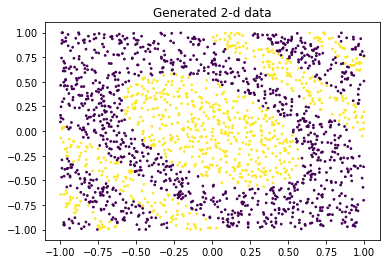

In [14]:
X = np.float32(np.random.uniform(-1,1,(2000, 2)))
Y = np.int64((((X * [[0.7,2]] + X[:,:1]) ** 2).sum(1) < 1) + (np.sin(4 * X.sum(1)**2) < -0.3))
print(np.bincount(Y))

# Spoilers!
pp.scatter(X[:,0],X[:,1],c=Y,s=3)
pp.title("Generated 2-d data")
pp.show()


PyTorch has these nice sampling helpers:

In [15]:
import torch.utils.data
tensor_data = torch.utils.data.TensorDataset(torch.tensor(X), torch.tensor(Y))
data = torch.utils.data.DataLoader(
    tensor_data,
    batch_size=32,
    sampler=torch.utils.data.sampler.RandomSampler(tensor_data)
)

In [16]:

# A small 3-layer neural network
nhid = 512
model = nn.Sequential(
    nn.Linear(2, nhid),
    nn.LeakyReLU(),
    nn.Linear(nhid, nhid),
    nn.LeakyReLU(),
    nn.Linear(nhid, 2))
# Initialize the weights properly
model.apply(weights_init)
print(model)

# Setup and optimizer
if i_has_gpus:
    model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Training loop
for epoch in range(101):
    total_loss = 0
    
    for x, y in data:
        
        if i_has_gpus:
            x = x.cuda()
            y = y.cuda()
            
        pred = model(x)
        loss = F.cross_entropy(pred, y)
        loss.backward()
        optimizer.step()
        
        # Keep track of the loss
        total_loss += loss.item()
        
    if not epoch % 10:
        print(epoch, total_loss)

Sequential(
  (0): Linear(in_features=2, out_features=512, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=512, out_features=512, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=512, out_features=2, bias=True)
)
0 40.64505469799042
10 28.67897403240204
20 25.555267602205276
30 27.2670815885067
40 23.21463719010353
50 21.58519634604454
60 21.866650097072124
70 21.19831809401512
80 24.32113154232502
90 15.670461177825928
100 17.34122894704342


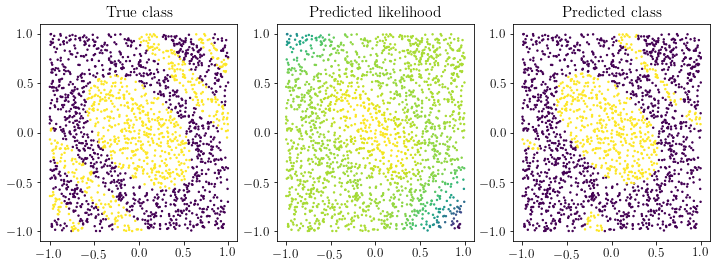

In [30]:
# Evaluate the entire training set
if i_has_gpus:
    predY = model(torch.tensor(X).cuda()).cpu()
else:
    predY = model(torch.tensor(X)).cpu()
# `detach` cuts the gradient connection to allow us to convert
# the tensor to a numpy array.
predY = predY.data.numpy()[:, 1]

# Some cool plotting
pp.figure(figsize=(12,4))
pp.subplot(1,3,1)
pp.scatter(X[:,0],X[:,1],c=Y,s=2)
pp.title("True class")
pp.subplot(1,3,2)
pp.scatter(X[:,0],X[:,1],c=predY,s=2)
pp.title("Predicted likelihood")
pp.subplot(1,3,3)
pp.scatter(X[:,0],X[:,1],c=predY > 0.5,s=2)
pp.title("Predicted class")
pp.show()

It is recommended to periodically save your models when running experiments. 

In [18]:
torch.save(model.state_dict(), "my_model.pkl")

To load the saved model, simply run:

In [19]:
model.load_state_dict(torch.load("my_model.pkl"))

# Plotting nice graphs
A nice graph can make all the difference in a paper or in a presentation.

Here are a couple of things a graph should (almost) **always** have:
- A title
- Labeled axes
- A legend for anything non-obvious

Here are things you *probably* want in your graph:
- Colours and shapes that make a **greyscale version** readable (Yes, I still print papers)
- LaTeX fonts (even if there's no math!)


In [20]:
# Using LaTeX:
pp.rc('text', usetex=True)
# 'sans-serif' fonts tend to look nicer in slides
# 'serif' fonts tend to look nicer in papers
pp.rc('font', family='serif', size=13)  

Now let's make a basic plot!

Think of matplotlib Figures as canvas, which you can repeatedly call "painting methods" on.

We will cover the following such methods today:
- `plot` & friends
- `scatter`
- `hist`ogram

Each of these methods will draw stuff *on top* of whatever is already drawn, with many default behaviours to try to make nice plots automatically.

## `plot`

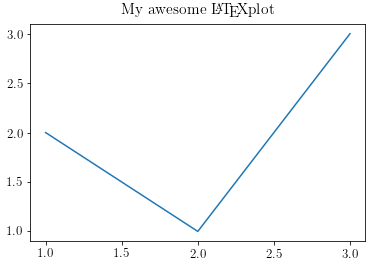

In [21]:
pp.clf()  # "Clear figure" creates a new figure with the default size
pp.plot([1,2,3],[2,1,3])
pp.title("My awesome \LaTeX plot")
pp.show()  # This will show the plot, but you could also do pp.savefig('myfig.png')

`plot` takes in a list of `x`s and `y`s, and connects them by a line, in the order that *you* give. This can lead to unfortunate results!

Here are some more useful functionalities:

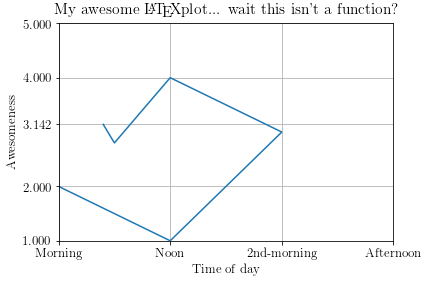

In [22]:
pp.clf()  # "Clear figure" creates a new figure with the default size
pp.plot([1,2,3,2,1.5,1.4],[2,1,3,4,2.8,np.pi])
# xlim specifies the left-right boundaries of the xaxis
pp.xlim(1,4)
pp.ylim(1,5)  # idem
# xticks allows to specify which ticks are shown on the xaxis,
# and optionally what labels are used to show them.
pp.xticks([1,2,3,4],['Morning','Noon','2nd-morning','Afternoon'])
pp.yticks([1,2,np.pi,4,5]) # idem
# grid overlays a grid on the default or specified xy-ticks
pp.grid()
pp.xlabel("Time of day")
pp.ylabel("Awesomeness")
pp.title("My awesome \LaTeX plot... wait this isn't a function?")
pp.show()

Repeat call to plots within the same figure to draw many things!

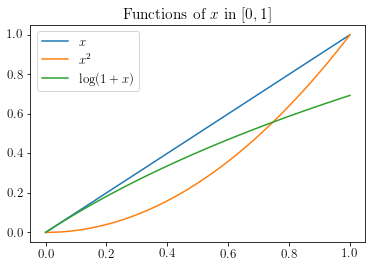

In [23]:
x = np.linspace(0, 1, 100)
pp.clf()
pp.plot(x, x, label='$x$')
pp.plot(x, x**2, label='$x^2$')
pp.plot(x, np.log(1+x), label='$\log(1+x)$')
# Legends are super useful!
pp.legend()
pp.title('Functions of $x$ in $[0,1]$')
pp.show()

## A small detour: `subplot(s)`

A very nice feature of matplotlib is its ability to plot many things in an orderly fashion in the same graph. This is done through the `subplot(nrows, ncols, index)` method.

This method sets up a `nrows` by `ncols` multigraph if it doesn't yet exist, and then `index` *selects* which subplot the following painting methods will operate on. Indices go from 1 to `nrows * ncols`, incrementing in row-major order. To draw on each subplot, one must successively select each subplot and draw on it.

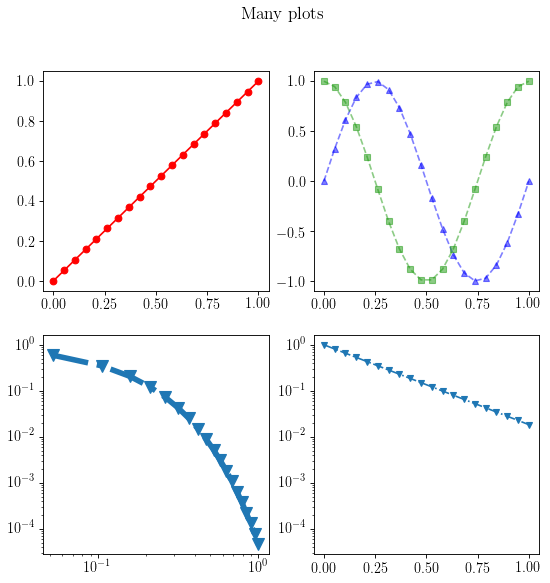

In [24]:
pp.figure(figsize=(8,8),  # figsize specifies the size, in inches ¯\_(ツ)_/¯
          dpi=80)         # dpi = pixels per inch

x = np.linspace(0, 1, 20)
pp.subplot(2, 2, 1)
# The third optional argument specifies a marker and the type of line used
# Possible line types: '-' | '--' | '-.' | ':'
# Common markers: .,ov^s
# (see https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html)
pp.plot(x, x, 'o-', c='red')

pp.subplot(2, 2, 2)
# alpha specifies the transparency of the plot
# the third argument can also specify the color as the first letter
pp.plot(x, np.sin(x*2*np.pi), 'b^--', c='blue', alpha=0.5)
# or colours can be rgb values
pp.plot(x, np.sin(x*2*np.pi+np.pi/2), 's--', c=(0.1,0.6,0.05), alpha=0.5)

ax = pp.subplot(2, 2, 3) # subplot returns an `Axes` object
# Some more options
pp.plot(x, np.e**(-10*x), 'v-.', markersize=10, linewidth=5) 
# Sets the axes in log-space
pp.semilogx() 
pp.semilogy()

# We can reuse the Axes object to share Axes
pp.subplot(2, 2, 4, sharey=ax)
pp.plot(x, np.e**(-4*x), 'v-.')



# This will give a title to the figure instead of the last selected subplot
pp.suptitle("Many plots")
pp.show()

### `fill_between`
A super useful method to draw standard deviations or uncertainty bounds.

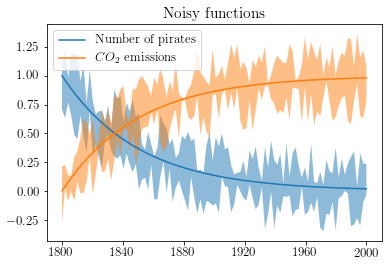

In [25]:
pp.clf()
x = np.linspace(0,1,100)
y = np.e**(-4*x)
pp.fill_between(x,
                y-np.random.uniform(0,0.4,(100,)),
                y+np.random.uniform(0,0.4,(100,)),
                alpha=0.5)
pp.plot(x, y, label='Number of pirates')
y = 1-np.e**(-4*x)
pp.fill_between(x,
                y-np.random.uniform(0,0.4,(100,)),
                y+np.random.uniform(0,0.4,(100,)),
                alpha=0.5)
pp.plot(x, y, label='$CO_2$ emissions')
pp.xticks(np.linspace(0,1,6), 
          np.int32(np.linspace(1800,2000,6)))
# the legend can have any location; there are some predefined
# 'digit' ones, e.g. '0' is "best", '2' is upper left.
pp.legend(loc=2)
pp.title("Noisy functions")
pp.show()

## `scatter`

Scatter plots are pretty much like line plots, except without the lines!

Here's some more differences, one can:
- color each marker differenty
- give each marker a different size

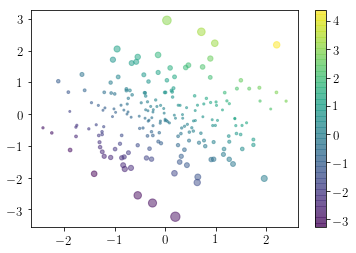

In [26]:
pp.clf()
np.random.seed(123)
x, y = np.random.normal(0,1,(200,2)).T
# The colors can be a 1-d array or an RGB array.If it is a
# 1-d array, coloring is done according to a `colormap` (which
# can be changed, but we don't go into that)
c = x+y
# Marker size
ms = 4+8*y**2
pp.scatter(x, y, c=c, s=ms, alpha=0.5)
# This is a color legend:
pp.colorbar()
pp.show()

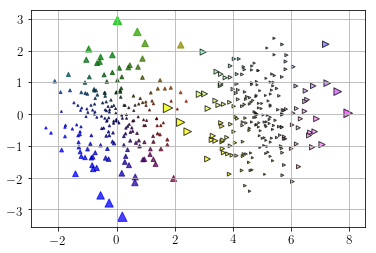

In [27]:
pp.clf()
np.random.seed(123)
x, y = np.random.normal(0,1,(200,2)).T
# Cool colors
c = np.clip(0.25 * np.array([x,y,1-x-y]).T, 0, 1)
ms = 4+8*y**2
# The same marker styles as for plot can be used:
pp.scatter(x, y, marker='^', c=c, s=ms, alpha=0.75)
pp.scatter(y+5, x, marker='>', c=1-c, s=ms, alpha=0.75, edgecolor='black')
pp.grid()
pp.show()

## `hist`
Histograms are pretty useful when looking at distributions.

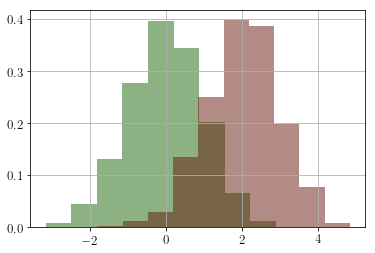

In [28]:
x = np.random.normal(0,1,1000)
pp.grid()
pp.hist(x, normed=1, facecolor=(0.1,0.4,0.04), alpha=0.5)
x = np.random.normal(2,1,1000)
pp.hist(x, normed=1, facecolor=(0.4,0.1,0.04), alpha=0.5)
pp.show()

You can also "manually" make histograms with `bar`.

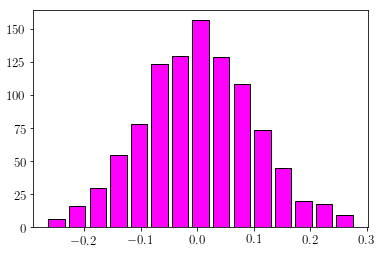

In [29]:
x = np.random.normal(0,.1,1000)
pp.clf()
bins, hist = np.histogram(x, 15)
binsize = (hist[1] - hist[0])
pp.bar(hist[:-1] + binsize/2, bins,
       facecolor='magenta',
       edgecolor='black',
       width=0.8*binsize)
pp.show()





# Emmanuel's random research tips


- There is no secret sauce; push yourself; respect yourself!
- Having a routine helps some people.
- Write! Write down your thoughts, the results of your experiments; practice explaining your ideas concisely.
- Read! But don't spend all your time reading, and don't feel bad for not reading the latest Deepmind paper.
- The lab is a great place to have your ideas challenged and improved; don't be shy!

How I go about a single idea:
1. Write down what, why, and how
2. Figure out a base case / eliminate as many confounding factors as possible
3. Code it
4. Figure out why it doesn't work
5. Goto 2

About the coding part:
- Separate experiments and logging from plotting (that way you can adjust your plotting routines without having to rerun experiments).
- Early on, log as many things as possible: gradients, rewards, variances, etc.
- Don't overthink your code, you will probably throw it away.
- Make nice plots! It helps you, it helps your advisor, it makes it easier to see what is missing 95% of the time.
